# Part 0: Imports

In [ ]:
from tensorflow.keras import *
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
!cp "/content/drive/MyDrive/xray.zip" "/";

In [ ]:
!unzip -q "/xray.zip" -d "/";

# Part 1 : Reading Data

In [ ]:
dataGenerator_normal = preprocessing.image.ImageDataGenerator(rescale = 1/255.0)
dataGenerator = preprocessing.image.ImageDataGenerator()

def get_data(path, normalize, shuff):
  if normalize:
    return dataGenerator_normal.flow_from_directory(
        path, target_size=(80,80), color_mode="grayscale", batch_size=32, shuffle=shuff)
  else:
    return dataGenerator.flow_from_directory(
        path, target_size=(80,80), color_mode="grayscale", batch_size=32, shuffle=shuff)
    
print('not normalized, not shuffled:')
dataTrain_noshuf, dataTest_noshuf = get_data("/Data/train", False, False), get_data("/Data/test", False, False)

print('normalized, not shuffled:')
dataTrain_noshuf_normal, dataTest_noshuf_normal = get_data("/Data/train", True, False), get_data("/Data/test", True, False)

print('not normalized, shuffled:')
dataTrain, dataTest = get_data("/Data/train", False, True), get_data("/Data/test", False, True)

print('normalized, shuffled:')
dataTrain_normal, dataTest_normal = get_data("/Data/train", True, True), get_data("/Data/test", True, True)

not normalized, not shuffled:
Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
normalized, not shuffled:
Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
not normalized, shuffled:
Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.
normalized, shuffled:
Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


# Part Two: Visualization

Found 5144 images belonging to 3 classes.


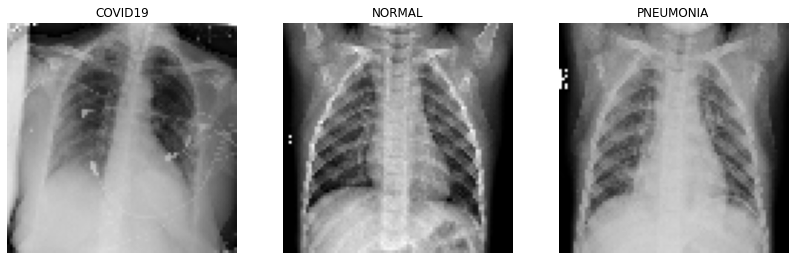

In [ ]:
current_class = 0
class_names = ['COVID19', 'NORMAL', 'PNEUMONIA']
dataPlot = dataGenerator.flow_from_directory("/Data/train", target_size=(80,80), color_mode="grayscale", batch_size=1, shuffle=False)

fig, ax = plt.subplots(1, 3, figsize=(14,5))

for i in range(len(dataPlot.classes)):
  if dataPlot.classes[i] == current_class:
    img = dataPlot[i+5][0][0]
    ax[current_class].imshow(img[:,:,0], cmap=plt.get_cmap('gray'))
    ax[current_class].set_axis_off()
    ax[current_class].set_title(class_names[current_class])
    current_class += 1

Text(0, 0.5, 'count')

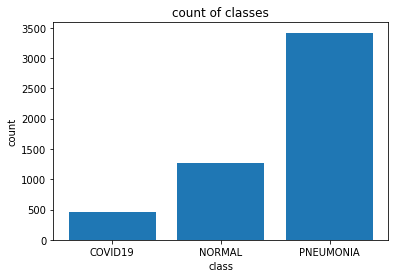

In [ ]:
counts = np.unique(dataPlot.classes, return_counts=True)
plt.bar(counts[0], counts[1], tick_label=class_names);
plt.title('count of classes')
plt.xlabel('class')
plt.ylabel('count')

# Part 3: Creating Model

In [ ]:
class Root:

  def __init__(self, d_train, d_test, d_train_noshuf, d_test_noshuf):
    self.model = None
    self.d_train = d_train
    self.d_test = d_test
    self.d_train_noshuf = d_train_noshuf
    self.d_test_noshuf = d_test_noshuf

  def create_model(self, act_func, reg=False, drop=False):
    
    kr = None
    if reg:
      kr = regularizers.L2(1e-4)
    
    dropout = lambda out : out
    if drop:
      dropout = lambda out: layers.Dropout(0.1)(out)

    input_layer = layers.Input(shape=(80, 80, 1))
    out = layers.Flatten()(input_layer)
    out = dropout(out)
    out = layers.Dense(512, activation= act_func, kernel_regularizer=kr)(out)
    out = dropout(out)
    out = layers.Dense(1024, activation= act_func, kernel_regularizer=kr)(out)
    out = dropout(out)
    out = layers.Dense(2048, activation= act_func, kernel_regularizer=kr)(out)
    out = dropout(out)
    out = layers.Dense(1024, activation= act_func, kernel_regularizer=kr)(out)
    out = dropout(out)
    out = layers.Dense(512, activation= act_func, kernel_regularizer=kr)(out)
    out = dropout(out)
    out = layers.Dense(3, activation= activations.softmax, kernel_regularizer=kr)(out)
    model = models.Model(inputs= input_layer, outputs= out)
    self.model = model
    return model

  def get_model(self):
    return self.model

  def compile(self, loss_func=losses.categorical_crossentropy, moment=0.0, optimizer='SGD'):
    opt = None
    print('optimizer =', optimizer)
    if optimizer=='SGD':
        opt = optimizers.SGD(learning_rate=0.01, momentum=moment)
    elif optimizer=='Adam':
        opt = optimizers.Adam(learning_rate=0.001)
    else:
      print('ERROR: I am not familiar with:', optimizer)
    self.model.compile(optimizer=opt, loss=loss_func, metrics=["accuracy"])
  
  def print_summary(self):
    self.model.summary()

  def plot_epochs(self, history):
    fig, ax = plt.subplots(1, 2, figsize=(18, 5))
    train_accs = history['accuracy']
    train_loss = history['loss']
    test_accs = history['val_accuracy']
    test_loss = history['val_loss']
    epoches = np.arange(len(train_accs))
    ax[0].plot(epoches, train_accs, test_accs)
    ax[0].legend()
    ax[0].set_title('accuracy per epoch')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'test'])

    ax[1].plot(epoches, train_loss, test_loss)
    ax[1].set_title('loss per epoch')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'test'])

  def fit(self, epochs):
    history = self.model.fit(self.d_train, validation_data= self.d_test, epochs=epochs)
    return history.history

  def __get_preds(self, y):
    y_pred_raw = self.model.predict(y)
    y_pred = np.rint(y_pred_raw).argmax(axis=1)
    return y_pred

  def print_reports(self):
    y_train_preds, y_test_preds = self.__get_preds(self.d_train_noshuf), self.__get_preds(self.d_test_noshuf)
    print('Classification Report For Train Data:')
    print('#'*60)
    print(classification_report(dataTrain.classes, y_train_preds))
    print('\nClassification Report For Test Data:')
    print('#'*60)
    print(classification_report(dataTest.classes, y_test_preds))

  def run(self, act_func, epochs, optimizer='SGD', moment=0.0, loss_func=losses.categorical_crossentropy, reg=False, drop=False):
    start_time = time.time()
    print('creating  model...', )
    self.create_model(act_func, reg, drop)
    print('\n')
    print('compiling model...', 'elapsed time = {} mins {:.2f} secs'.format((time.time()-start_time)//60, (time.time()-start_time)%60))
    self.compile(loss_func, moment, optimizer)
    print('\n')
    print('training  model...', 'elapsed time = {} mins {:.2f} secs'.format((time.time()-start_time)//60, (time.time()-start_time)%60))
    history = self.fit(epochs)
    print('\n')
    print('plotting epochs...', 'elapsed time = {} mins {:.2f} secs'.format((time.time()-start_time)//60, (time.time()-start_time)%60))
    self.plot_epochs(history)
    print('\n')
    print('printing reports...','elapsed time = {} mins {:.2f} secs'.format((time.time()-start_time)//60, (time.time()-start_time)%60))
    self.print_reports()
    print('\n')
    print('elapsed time = {} mins {} secs'.format((time.time()-start_time)//60, (time.time()-start_time)%60))

In [ ]:
root_relu = Root(None, None, None, None)
root_relu.create_model(activations.relu)
root_relu.print_summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               3277312   
_________________________________________________________________
dense_31 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_32 (Dense)             (None, 2048)              2099200   
_________________________________________________________________
dense_33 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_34 (Dense)             (None, 512)               5248

There are a total of 8,526,339 parameters which is equal to **\\(6401\times512 + 513\times1024 + 1025\times2048 + 2049\times1024 + 1025\times512 + 513\times3\\)** because for example the W matrix of the first second hidden layer is 6400*512 and there are 512 bias values so totally there are (6400 + 1)*512 parameters in this layer.

# Part 4: Training Model

### 4.1 Relu:

creating  model...


compiling model... elapsed time = 0.0 mins 0.07 secs
optimizer = SGD


training  model... elapsed time = 0.0 mins 0.08 secs
Epoch 1/10
161/161 [==============================] - 171s 1s/step - loss: nan - accuracy: 0.1226 - val_loss: nan - val_accuracy: 0.0901
Epoch 2/10
161/161 [==============================] - 170s 1s/step - loss: nan - accuracy: 0.0906 - val_loss: nan - val_accuracy: 0.0901
Epoch 3/10
161/161 [==============================] - 170s 1s/step - loss: nan - accuracy: 0.0879 - val_loss: nan - val_accuracy: 0.0901
Epoch 4/10
161/161 [==============================] - 169s 1s/step - loss: nan - accuracy: 0.0894 - val_loss: nan - val_accuracy: 0.0901
Epoch 5/10
161/161 [==============================] - 170s 1s/step - loss: nan - accuracy: 0.0895 - val_loss: nan - val_accuracy: 0.0901
Epoch 6/10
161/161 [==============================] - 170s 1s/step - loss: nan - accuracy: 0.0927 - val_loss: nan - val_accuracy: 0.0901
Epoch 7/10
161/161 [=============

No handles with labels found to put in legend.
No handles with labels found to put in legend.




plotting epochs... elapsed time = 28.0 mins 21.99 secs


printing reports... elapsed time = 28.0 mins 22.04 secs
Classification Report For Train Data:
############################################################
              precision    recall  f1-score   support

           0       0.09      1.00      0.16       460
           1       0.00      0.00      0.00      1266
           2       0.00      0.00      0.00      3418

    accuracy                           0.09      5144
   macro avg       0.03      0.33      0.05      5144
weighted avg       0.01      0.09      0.01      5144


Classification Report For Test Data:
############################################################
              precision    recall  f1-score   support

           0       0.09      1.00      0.17       116
           1       0.00      0.00      0.00       317
           2       0.00      0.00      0.00       855

    accuracy                           0.09      1288
   macro avg       0.03      0.33 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


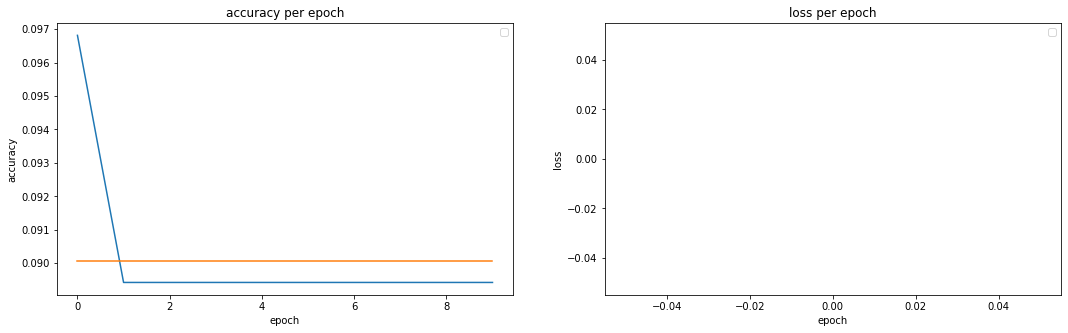

In [ ]:
root_relu = Root(dataTrain, dataTest, dataTrain_noshuf, dataTest_noshuf)
root_relu.run(activations.relu, epochs=10)

#### 4.1 Result:
As we can see above, after some iterations, the loss value we be so much large that it may cause overflow and we seen that the loss values are **nan**. We know that relu does not put a upper bound for it's output and because here we **have not normalized** the data, so as the outputs passes through the layers it gets larger and larger, hence the loss and gradients will be also extremely large and eventualy cause overflow. Thus the accuracy is dropped to near zero and loss in nan so it can not be plot.

### 4.2: Tanh

creating  model...


compiling model... elapsed time = 0.0 mins 0.06 secs
optimizer = SGD


training  model... elapsed time = 0.0 mins 0.07 secs
Epoch 1/10
161/161 [==============================] - 169s 1s/step - loss: 1.1778 - accuracy: 0.5635 - val_loss: 0.8615 - val_accuracy: 0.6638
Epoch 2/10
161/161 [==============================] - 168s 1s/step - loss: 0.8713 - accuracy: 0.6562 - val_loss: 0.8449 - val_accuracy: 0.6638
Epoch 3/10
161/161 [==============================] - 168s 1s/step - loss: 0.8496 - accuracy: 0.6683 - val_loss: 0.8525 - val_accuracy: 0.6638
Epoch 4/10
161/161 [==============================] - 169s 1s/step - loss: 0.8368 - accuracy: 0.6743 - val_loss: 0.8525 - val_accuracy: 0.6638
Epoch 5/10
161/161 [==============================] - 169s 1s/step - loss: 0.8480 - accuracy: 0.6621 - val_loss: 0.8635 - val_accuracy: 0.6638
Epoch 6/10
161/161 [==============================] - 166s 1s/step - loss: 0.8706 - accuracy: 0.6493 - val_loss: 0.8370 - val_accuracy: 0.66

No handles with labels found to put in legend.
No handles with labels found to put in legend.




plotting epochs... elapsed time = 27.0 mins 44.33 secs


printing reports... elapsed time = 27.0 mins 44.37 secs
Classification Report For Train Data:
############################################################
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       460
           1       0.00      0.00      0.00      1266
           2       0.66      1.00      0.80      3418

    accuracy                           0.66      5144
   macro avg       0.22      0.33      0.27      5144
weighted avg       0.44      0.66      0.53      5144


Classification Report For Test Data:
############################################################
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.00      0.00      0.00       317
           2       0.66      1.00      0.80       855

    accuracy                           0.66      1288
   macro avg       0.22      0.33 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


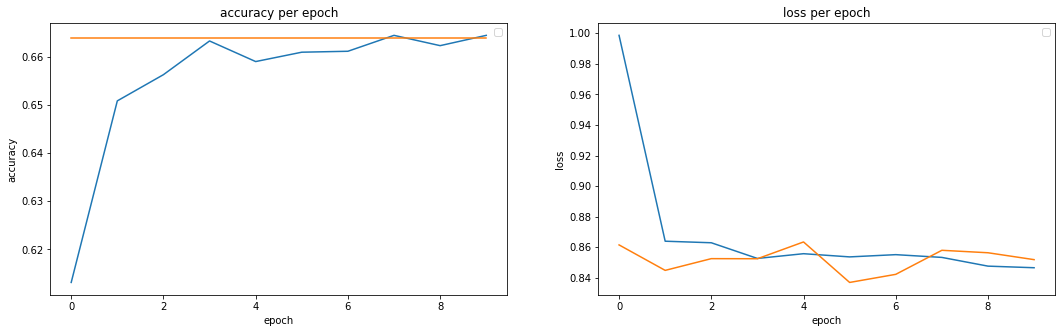

In [ ]:
root_tanh = Root(dataTrain, dataTest, dataTrain_noshuf, dataTest_noshuf)
root_tanh.run(activations.tanh, epochs=10)

### 4.2 Result:
As we can see above the loss values has not overflowed this time, because tanh bounds the output between (-1, 1) but as we see the results are not good ecpecially in class 0 and 1.

### 4.3 Comparisoin:
As we can see both tanh has better performance that relu which is ,as we said above, because of the bounds that it puts on it's output and this way it prevents the overflow. The bad performance of both is for one main cause: **Data is not normalized** so it can be very large and cause overflow.
Solution: **Normalize The Data**

# Part 5: Normalization

In [ ]:
root = Root(dataTrain_normal, dataTest_normal, dataTrain_noshuf_normal, dataTest_noshuf_normal)

creating  model...


compiling model... elapsed time = 0.0 mins 0.08 secs
optimizer = SGD


training  model... elapsed time = 0.0 mins 0.09 secs
Epoch 1/10
161/161 [==============================] - 168s 1s/step - loss: 0.7142 - accuracy: 0.6885 - val_loss: 0.4749 - val_accuracy: 0.8075
Epoch 2/10
161/161 [==============================] - 166s 1s/step - loss: 0.4684 - accuracy: 0.8126 - val_loss: 0.3429 - val_accuracy: 0.8703
Epoch 3/10
161/161 [==============================] - 165s 1s/step - loss: 0.3699 - accuracy: 0.8594 - val_loss: 0.3660 - val_accuracy: 0.8548
Epoch 4/10
161/161 [==============================] - 164s 1s/step - loss: 0.3256 - accuracy: 0.8741 - val_loss: 0.2956 - val_accuracy: 0.8773
Epoch 5/10
161/161 [==============================] - 164s 1s/step - loss: 0.3011 - accuracy: 0.8856 - val_loss: 0.2207 - val_accuracy: 0.9169
Epoch 6/10
161/161 [==============================] - 163s 1s/step - loss: 0.2853 - accuracy: 0.8907 - val_loss: 0.2148 - val_accuracy: 0.92

No handles with labels found to put in legend.
No handles with labels found to put in legend.




plotting epochs... elapsed time = 27.0 mins 18.42 secs


printing reports... elapsed time = 27.0 mins 18.47 secs
Classification Report For Train Data:
############################################################
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       460
           1       0.97      0.61      0.75      1266
           2       0.87      0.99      0.93      3418

    accuracy                           0.89      5144
   macro avg       0.90      0.84      0.85      5144
weighted avg       0.90      0.89      0.88      5144


Classification Report For Test Data:
############################################################
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       116
           1       0.96      0.68      0.80       317
           2       0.89      0.98      0.93       855

    accuracy                           0.90      1288
   macro avg       0.92      0.87 

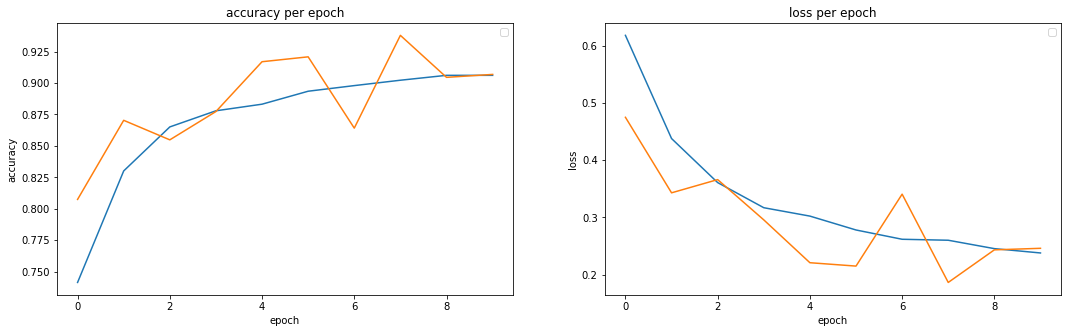

In [ ]:
root.run(activations.relu, epochs=10)

# Part 6: Optimizers

### 6.1: What is Momentum?:
  Recall that in SGD the updates are only based on the current gradient; in momentum updates are based on an aggregate of the current gradient and past gradient which is caculated as the exponential moving average of the current and past gradients. Using momentum, we can make the model learn faster and prevent from getting stuck in a local monima(local optimum). Also momentum results in more smooth variations.

### 6.2: Trying Different Momentums:

#### Momentum = 0.5
As we can see below, using this value of momentum, has resulted in a more smoothe variations in both train test data: 

creating  model...


compiling model... elapsed time = 0.0 mins 0.06 secs
optimizer = SGD


training  model... elapsed time = 0.0 mins 0.07 secs
Epoch 1/10
161/161 [==============================] - 163s 1s/step - loss: 0.6575 - accuracy: 0.7309 - val_loss: 0.3372 - val_accuracy: 0.8634
Epoch 2/10
161/161 [==============================] - 161s 1000ms/step - loss: 0.3699 - accuracy: 0.8594 - val_loss: 0.2437 - val_accuracy: 0.9045
Epoch 3/10
161/161 [==============================] - 160s 997ms/step - loss: 0.2875 - accuracy: 0.8898 - val_loss: 0.1975 - val_accuracy: 0.9348
Epoch 4/10
161/161 [==============================] - 160s 998ms/step - loss: 0.2939 - accuracy: 0.8886 - val_loss: 0.2333 - val_accuracy: 0.9107
Epoch 5/10
161/161 [==============================] - 160s 994ms/step - loss: 0.2513 - accuracy: 0.9044 - val_loss: 0.1755 - val_accuracy: 0.9363
Epoch 6/10
161/161 [==============================] - 159s 986ms/step - loss: 0.2651 - accuracy: 0.8966 - val_loss: 0.2132 - va

No handles with labels found to put in legend.
No handles with labels found to put in legend.




plotting epochs... elapsed time = 26.0 mins 33.02 secs


printing reports... elapsed time = 26.0 mins 33.07 secs
Classification Report For Train Data:
############################################################
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       460
           1       0.67      0.97      0.79      1266
           2       0.98      0.82      0.89      3418

    accuracy                           0.86      5144
   macro avg       0.85      0.90      0.86      5144
weighted avg       0.90      0.86      0.87      5144


Classification Report For Test Data:
############################################################
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       116
           1       0.73      0.97      0.83       317
           2       0.99      0.86      0.92       855

    accuracy                           0.90      1288
   macro avg       0.88      0.92 

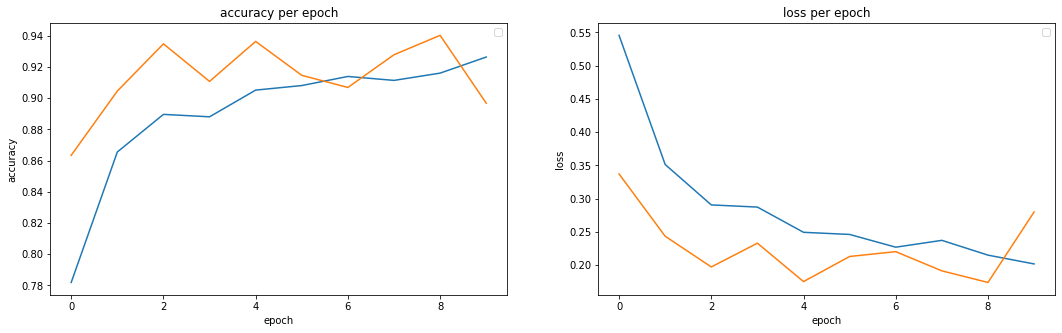

In [ ]:
root.run(activations.relu, moment=0.5, epochs=10)

### Momentum = 0.9:
As we can see here, the result is even more smooth than the time we used momentum=0.5. Also obviously the model has learned much faster and the accuracy and f1 has rised from about 90 to about 94 in 10 epochs.

creating  model...


compiling model... elapsed time = 0.0 mins 0.06 secs
optimizer = SGD


training  model... elapsed time = 0.0 mins 0.08 secs
Epoch 1/10
161/161 [==============================] - 165s 1s/step - loss: 0.6968 - accuracy: 0.7050 - val_loss: 0.2383 - val_accuracy: 0.9193
Epoch 2/10
161/161 [==============================] - 160s 998ms/step - loss: 0.3406 - accuracy: 0.8728 - val_loss: 0.2809 - val_accuracy: 0.8727
Epoch 3/10
161/161 [==============================] - 159s 990ms/step - loss: 0.3263 - accuracy: 0.8854 - val_loss: 0.1953 - val_accuracy: 0.9216
Epoch 4/10
161/161 [==============================] - 158s 982ms/step - loss: 0.2736 - accuracy: 0.8940 - val_loss: 0.1776 - val_accuracy: 0.9387
Epoch 5/10
161/161 [==============================] - 159s 988ms/step - loss: 0.2704 - accuracy: 0.9014 - val_loss: 0.1991 - val_accuracy: 0.9255
Epoch 6/10
161/161 [==============================] - 160s 998ms/step - loss: 0.2450 - accuracy: 0.9086 - val_loss: 0.2034 - val

No handles with labels found to put in legend.
No handles with labels found to put in legend.




plotting epochs... elapsed time = 26.0 mins 40.66 secs


printing reports... elapsed time = 26.0 mins 40.70 secs
Classification Report For Train Data:
############################################################
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       460
           1       0.90      0.88      0.89      1266
           2       0.96      0.95      0.95      3418

    accuracy                           0.93      5144
   macro avg       0.90      0.91      0.91      5144
weighted avg       0.93      0.93      0.93      5144


Classification Report For Test Data:
############################################################
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       116
           1       0.90      0.92      0.91       317
           2       0.97      0.95      0.96       855

    accuracy                           0.94      1288
   macro avg       0.92      0.94 

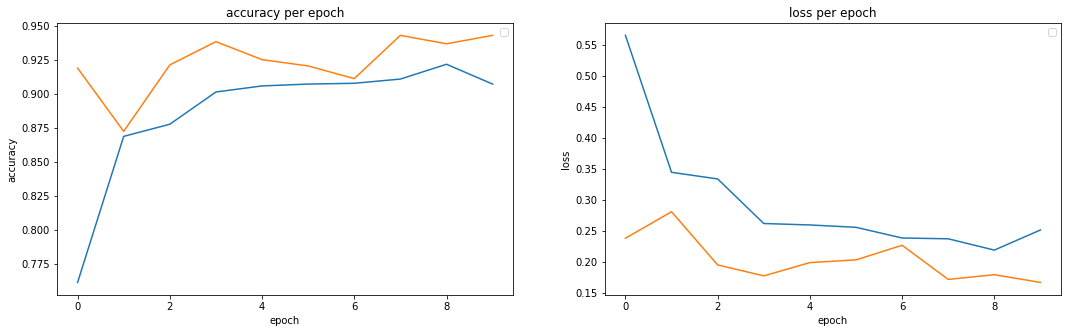

In [ ]:
root.run(activations.relu, moment=0.9, epochs=10)

### Momentum = 0.99
As we can see, after 4 epochs the results have been very bad and the accuracy is dropped suddenly and loss has risen so much.This is because this time the momentum is very high(near 1) and it causes to the model, lose the global minimum because the steps are large at each iterations. 

creating  model...


compiling model... elapsed time = 0.0 mins 0.06 secs
optimizer = SGD


training  model... elapsed time = 0.0 mins 0.07 secs
Epoch 1/10
161/161 [==============================] - 158s 981ms/step - loss: 0.7273 - accuracy: 0.7006 - val_loss: 0.4252 - val_accuracy: 0.8478
Epoch 2/10
161/161 [==============================] - 158s 981ms/step - loss: 0.4847 - accuracy: 0.8312 - val_loss: 0.5386 - val_accuracy: 0.8548
Epoch 3/10
161/161 [==============================] - 157s 976ms/step - loss: 0.4517 - accuracy: 0.8490 - val_loss: 0.2974 - val_accuracy: 0.8936
Epoch 4/10
161/161 [==============================] - 156s 969ms/step - loss: 0.5085 - accuracy: 0.8323 - val_loss: 0.3077 - val_accuracy: 0.8820
Epoch 5/10
161/161 [==============================] - 156s 969ms/step - loss: 0.9750 - accuracy: 0.7943 - val_loss: 0.9262 - val_accuracy: 0.6638
Epoch 6/10
161/161 [==============================] - 156s 971ms/step - loss: 0.9911 - accuracy: 0.6559 - val_loss: 0.8808 - 

No handles with labels found to put in legend.
No handles with labels found to put in legend.




plotting epochs... elapsed time = 26.0 mins 4.76 secs


printing reports... elapsed time = 26.0 mins 4.80 secs
Classification Report For Train Data:
############################################################
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       460
           1       0.00      0.00      0.00      1266
           2       0.66      1.00      0.80      3418

    accuracy                           0.66      5144
   macro avg       0.22      0.33      0.27      5144
weighted avg       0.44      0.66      0.53      5144


Classification Report For Test Data:
############################################################
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.00      0.00      0.00       317
           2       0.66      1.00      0.80       855

    accuracy                           0.66      1288
   macro avg       0.22      0.33   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


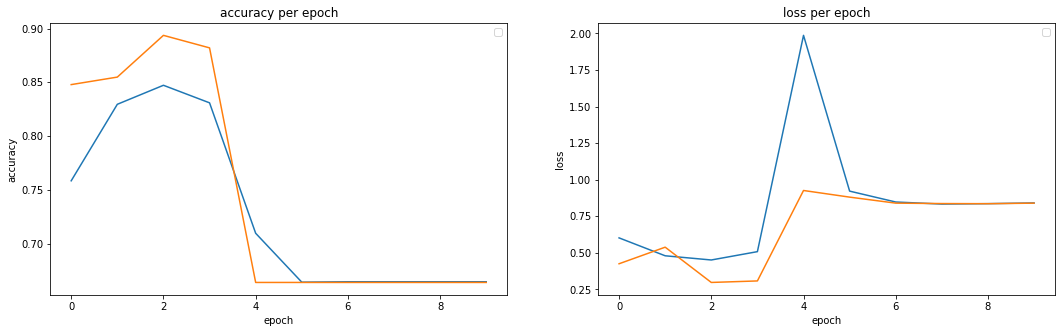

In [ ]:
root.run(activations.relu, moment=0.99, epochs=10)

### 6.3: Is large momentum always helpful?
When momentum is very large the learning rate is better to be small because if both momentum and learning rate is large, we may skip the global minimum which results in finding a sub-optimal solution.


### 6.4: Adam Optimizer
There are two main extentions for stochastic gradient descent: 1-adaptive gradient descent and 2-root mean square propagation. Adam is an optimization algorithm which is used instead of SGD and takes the adavantages of these two extentions. This algorithm maintains the exponential running average of both gradient and squared gradient over the time and controls the decay rates of these averages by two parameters beta1 and beta2.

creating  model...


compiling model... elapsed time = 0.0 mins 0.06 secs
optimizer = Adam


training  model... elapsed time = 0.0 mins 0.07 secs
Epoch 1/10
161/161 [==============================] - 159s 984ms/step - loss: 0.9770 - accuracy: 0.6834 - val_loss: 0.2567 - val_accuracy: 0.9030
Epoch 2/10
161/161 [==============================] - 158s 980ms/step - loss: 0.3445 - accuracy: 0.8784 - val_loss: 0.3523 - val_accuracy: 0.8657
Epoch 3/10
161/161 [==============================] - 158s 979ms/step - loss: 0.3472 - accuracy: 0.8764 - val_loss: 0.2195 - val_accuracy: 0.9255
Epoch 4/10
161/161 [==============================] - 158s 981ms/step - loss: 0.2876 - accuracy: 0.8978 - val_loss: 0.2365 - val_accuracy: 0.9068
Epoch 5/10
161/161 [==============================] - 158s 982ms/step - loss: 0.2701 - accuracy: 0.9025 - val_loss: 0.2360 - val_accuracy: 0.9146
Epoch 6/10
161/161 [==============================] - 157s 978ms/step - loss: 0.2363 - accuracy: 0.9171 - val_loss: 0.1754 -

No handles with labels found to put in legend.
No handles with labels found to put in legend.




plotting epochs... elapsed time = 26.0 mins 7.46 secs


printing reports... elapsed time = 26.0 mins 7.50 secs
Classification Report For Train Data:
############################################################
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       460
           1       0.96      0.72      0.83      1266
           2       0.90      0.99      0.94      3418

    accuracy                           0.91      5144
   macro avg       0.92      0.86      0.89      5144
weighted avg       0.92      0.91      0.91      5144


Classification Report For Test Data:
############################################################
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       116
           1       0.96      0.78      0.86       317
           2       0.91      0.99      0.95       855

    accuracy                           0.92      1288
   macro avg       0.94      0.87   

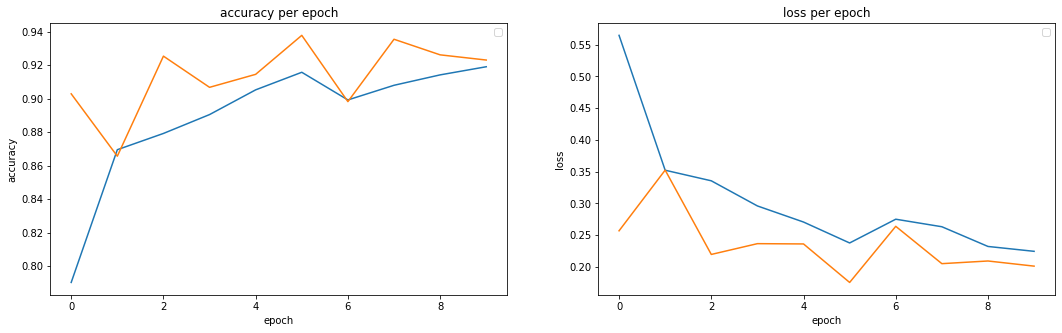

In [ ]:
root.run(activations.relu, epochs=10, optimizer='Adam')

#### Result:
 As we can see above the accuracy on the test data is above 90% in the first epoch, so Adam optimizer has helped the model to learn faster that SGD.

# Part 7: Epoch Impact

### 7.1: Training In 20 Epochs

creating  model...


compiling model... elapsed time = 0.0 mins 5.63 secs
optimizer = Adam


training  model... elapsed time = 0.0 mins 5.64 secs
Epoch 1/20
161/161 [==============================] - 144s 885ms/step - loss: 0.9473 - accuracy: 0.6907 - val_loss: 0.3920 - val_accuracy: 0.8564
Epoch 2/20
161/161 [==============================] - 142s 882ms/step - loss: 0.3336 - accuracy: 0.8794 - val_loss: 0.4914 - val_accuracy: 0.8377
Epoch 3/20
161/161 [==============================] - 142s 881ms/step - loss: 0.3023 - accuracy: 0.8965 - val_loss: 0.4159 - val_accuracy: 0.8517
Epoch 4/20
161/161 [==============================] - 142s 881ms/step - loss: 0.2969 - accuracy: 0.8878 - val_loss: 0.2961 - val_accuracy: 0.8921
Epoch 5/20
161/161 [==============================] - 142s 880ms/step - loss: 0.2835 - accuracy: 0.8948 - val_loss: 0.2147 - val_accuracy: 0.9317
Epoch 6/20
161/161 [==============================] - 142s 885ms/step - loss: 0.3069 - accuracy: 0.8863 - val_loss: 0.1891 -

No handles with labels found to put in legend.
No handles with labels found to put in legend.




plotting epochs... elapsed time = 47.0 mins 28.97 secs


printing reports... elapsed time = 47.0 mins 29.01 secs
Classification Report For Train Data:
############################################################
              precision    recall  f1-score   support

           0       0.97      0.77      0.86       460
           1       0.77      0.96      0.85      1266
           2       0.97      0.91      0.94      3418

    accuracy                           0.91      5144
   macro avg       0.90      0.88      0.88      5144
weighted avg       0.92      0.91      0.91      5144


Classification Report For Test Data:
############################################################
              precision    recall  f1-score   support

           0       0.98      0.68      0.80       116
           1       0.76      0.95      0.85       317
           2       0.97      0.92      0.94       855

    accuracy                           0.91      1288
   macro avg       0.90      0.85 

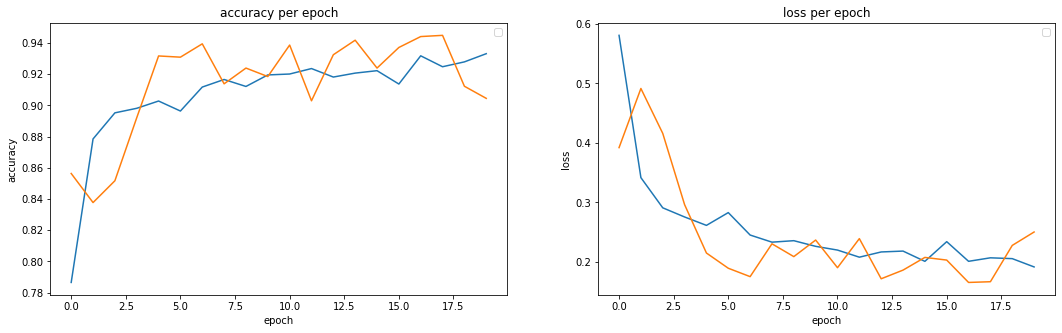

In [ ]:
root.run(activations.relu, epochs=20, optimizer='Adam')

### 7.2: Why we usually train the model in several epochs?
In short: we don't have enough data. Usually the neural networks required nowadays are so much big that they have millions of parameters, so for learning all these parameters and reaching the desired performances, these networks need lots of labeld data which is known to be very expensive to obtain or produce. So to overcome this lack of data, we use the data we have, several times by making multiple passes over the data through epochs.

### 7.3: Too Many Epochs:
If we train the model in too many epoches, there is a chance of overfitting which is caused by the model learning not only the training data but also the noises which results in lack of generalization on other datasets. Also it wastes time and energy with no gain. One approach to overcome this is early stopping which is to stop training the model when we see that the loss is not decreasing anymore or even increasing.

# Part 8: Loss Function Impact

### 8.1: Using MSE As Loss Function

creating  model...


compiling model... elapsed time = 0.0 mins 0.05 secs
optimizer = Adam


training  model... elapsed time = 0.0 mins 0.06 secs
Epoch 1/20
161/161 [==============================] - 144s 894ms/step - loss: 0.2252 - accuracy: 0.6640 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 2/20
161/161 [==============================] - 144s 896ms/step - loss: 0.2173 - accuracy: 0.6741 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 3/20
161/161 [==============================] - 144s 896ms/step - loss: 0.2204 - accuracy: 0.6694 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 4/20
161/161 [==============================] - 142s 884ms/step - loss: 0.2229 - accuracy: 0.6657 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 5/20
161/161 [==============================] - 141s 878ms/step - loss: 0.2239 - accuracy: 0.6642 - val_loss: 0.2241 - val_accuracy: 0.6638
Epoch 6/20
161/161 [==============================] - 141s 878ms/step - loss: 0.2238 - accuracy: 0.6643 - val_loss: 0.2241 -

No handles with labels found to put in legend.




plotting epochs... elapsed time = 47.0 mins 8.00 secs


printing reports... elapsed time = 47.0 mins 8.03 secs
Classification Report For Train Data:
############################################################
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       460
           1       0.00      0.00      0.00      1266
           2       0.66      1.00      0.80      3418

    accuracy                           0.66      5144
   macro avg       0.22      0.33      0.27      5144
weighted avg       0.44      0.66      0.53      5144


Classification Report For Test Data:
############################################################
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.00      0.00      0.00       317
           2       0.66      1.00      0.80       855

    accuracy                           0.66      1288
   macro avg       0.22      0.33   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


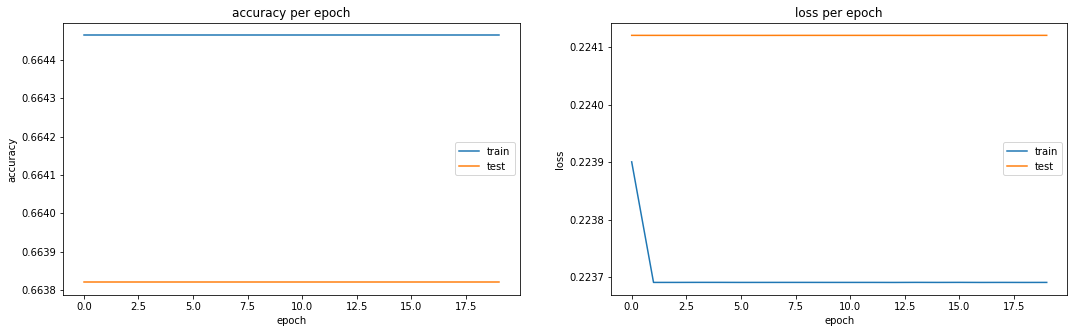

In [ ]:
root.run(activations.relu, epochs=20, optimizer='Adam', loss_func=losses.mse)

#### Result:
As we can see the model has not learned at all and the accuracy and loss is steady till the end. As it is apparent from classification report, the model has never decided class 0 and 1 and always have decided 2 which is because the class 2 data is much larger that the two others.

### Why Is MSE Not Suitable For Classification? When Do We Use It?
There are two reasons that MSE is not suitable for classification tasks. First reason is that MSE is used when we assume that the output is generated from a gaussian distribution(continous) while it may be not. When we face a classification problem, the outputs are not continuous but discrete and hence the outputs are kinda from bernoulli distribution(we can view the muliticlass problem as a combination of several binary problems). The second reason is that the MSE is not convex and for some choice of initial weights it will stuck while learning. MSE is used for linear regression where we suppose that the data has a gaussian distribution, in that condition MSE is proved by Maximum Likelihood to have the best performance. 

# Part 9: 

creating  model...


compiling model... elapsed time = 0.0 mins 0.05 secs
optimizer = Adam


training  model... elapsed time = 0.0 mins 0.06 secs
Epoch 1/20
161/161 [==============================] - 144s 894ms/step - loss: 1.2582 - accuracy: 0.6713 - val_loss: 0.7545 - val_accuracy: 0.8408
Epoch 2/20
161/161 [==============================] - 143s 890ms/step - loss: 0.5806 - accuracy: 0.8659 - val_loss: 0.4702 - val_accuracy: 0.9154
Epoch 3/20
161/161 [==============================] - 143s 890ms/step - loss: 0.4843 - accuracy: 0.8910 - val_loss: 0.3350 - val_accuracy: 0.9340
Epoch 4/20
161/161 [==============================] - 143s 889ms/step - loss: 0.4136 - accuracy: 0.9046 - val_loss: 0.3576 - val_accuracy: 0.9154
Epoch 5/20
161/161 [==============================] - 143s 890ms/step - loss: 0.3724 - accuracy: 0.9064 - val_loss: 0.3339 - val_accuracy: 0.9270
Epoch 6/20
161/161 [==============================] - 143s 889ms/step - loss: 0.3668 - accuracy: 0.9112 - val_loss: 0.3073 -

No handles with labels found to put in legend.




plotting epochs... elapsed time = 47.0 mins 38.87 secs


printing reports... elapsed time = 47.0 mins 38.90 secs
Classification Report For Train Data:
############################################################
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       460
           1       0.76      0.96      0.85      1266
           2       0.98      0.88      0.93      3418

    accuracy                           0.91      5144
   macro avg       0.89      0.92      0.90      5144
weighted avg       0.92      0.91      0.91      5144


Classification Report For Test Data:
############################################################
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       116
           1       0.77      0.97      0.86       317
           2       0.98      0.90      0.94       855

    accuracy                           0.91      1288
   macro avg       0.89      0.92 

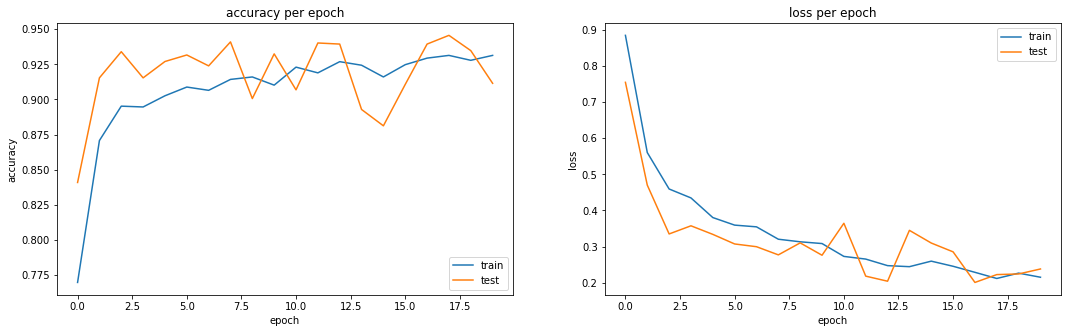

In [ ]:
root.run(activations.relu, epochs=20, optimizer='Adam', reg=True)

#### Result:
L2-Regularization is a method for decreasing the variance of the performance which means to avoid overfitting onthe train data and have better performance on test data(increase generalization. As we see in the plots, the pattern of decrease in train and test are similar and loss on test data is not fluctuating a lot like before. 

creating  model...


compiling model... elapsed time = 0.0 mins 0.05 secs
optimizer = Adam


training  model... elapsed time = 0.0 mins 0.06 secs
Epoch 1/20
161/161 [==============================] - 144s 893ms/step - loss: 0.9302 - accuracy: 0.7028 - val_loss: 0.3621 - val_accuracy: 0.8766
Epoch 2/20
161/161 [==============================] - 143s 891ms/step - loss: 0.4214 - accuracy: 0.8428 - val_loss: 0.2506 - val_accuracy: 0.9193
Epoch 3/20
161/161 [==============================] - 143s 889ms/step - loss: 0.3732 - accuracy: 0.8693 - val_loss: 0.3492 - val_accuracy: 0.9030
Epoch 4/20
161/161 [==============================] - 143s 890ms/step - loss: 0.3851 - accuracy: 0.8551 - val_loss: 0.3446 - val_accuracy: 0.9177
Epoch 5/20
161/161 [==============================] - 143s 891ms/step - loss: 0.3502 - accuracy: 0.8796 - val_loss: 0.2680 - val_accuracy: 0.9177
Epoch 6/20
161/161 [==============================] - 143s 889ms/step - loss: 0.3674 - accuracy: 0.8634 - val_loss: 0.2271 -

No handles with labels found to put in legend.




plotting epochs... elapsed time = 47.0 mins 46.47 secs


printing reports... elapsed time = 47.0 mins 46.50 secs
Classification Report For Train Data:
############################################################
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       460
           1       0.86      0.88      0.87      1266
           2       0.96      0.93      0.95      3418

    accuracy                           0.92      5144
   macro avg       0.87      0.92      0.89      5144
weighted avg       0.92      0.92      0.92      5144


Classification Report For Test Data:
############################################################
              precision    recall  f1-score   support

           0       0.83      0.97      0.89       116
           1       0.87      0.91      0.89       317
           2       0.97      0.93      0.95       855

    accuracy                           0.93      1288
   macro avg       0.89      0.94 

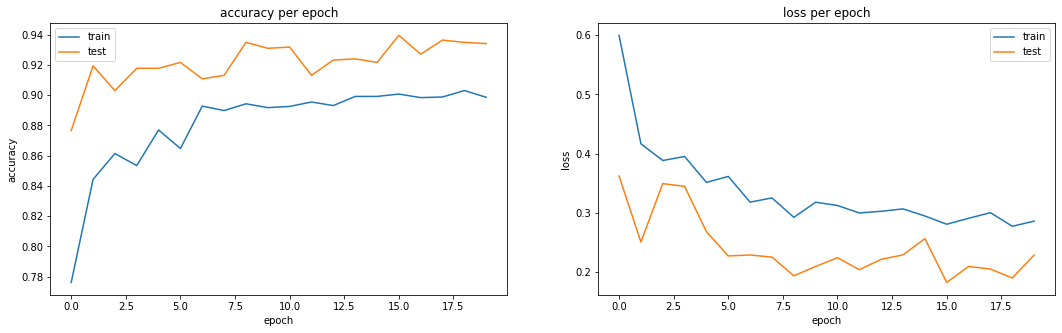

In [ ]:
root.run(activations.relu, epochs=20, optimizer='Adam', drop=True)

#### Result:
Dropout is another regularization method. An approach to avoid overfitting is to train differrent structure of neural networks and averaging the results. Because this method is costly and not so much practical, we simulate this by randomly removing some nodes from layers of one neural network. This way we can prevent overfitting and increase the generalization of the model. An impact of using this method, is the increased noise in the steps, because of that randomness which is apparent in the above plots. As we can see the f1 score and accuracy is as desired on train dataset as well as test dataset.